# **Fake New Clasification**

In [71]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
import warnings
warnings.filterwarnings('ignore')
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fake-news-classification/train (2).csv
/kaggle/input/fake-news-classification/evaluation.csv
/kaggle/input/fake-news-classification/test (1).csv


In [72]:
url_train='/kaggle/input/fake-news-classification/train (2).csv'
url_test='/kaggle/input/fake-news-classification/test (1).csv'

In [73]:
train=pd.read_csv(url_train,sep=';')
test=pd.read_csv(url_test,sep=';')

In [74]:
# Vacios
print(train.isnull().sum())
print('------------------')
print(test.isnull().sum())

Unnamed: 0    0
title         0
text          0
label         0
dtype: int64
------------------
Unnamed: 0    0
title         0
text          0
label         0
dtype: int64


In [75]:
# drop indice
train.drop('Unnamed: 0',inplace=True,axis=1)
test.drop('Unnamed: 0',inplace=True,axis=1)

In [76]:
# Verificar duplicados
train=train.drop_duplicates()
print(f"Duplicados: {train.duplicated().sum()}")
print(f"Duplicados : {test.duplicated().sum()}")

Duplicados: 0
Duplicados : 0


## **EDA**

label
1    13246
0    11106
Name: count, dtype: int64


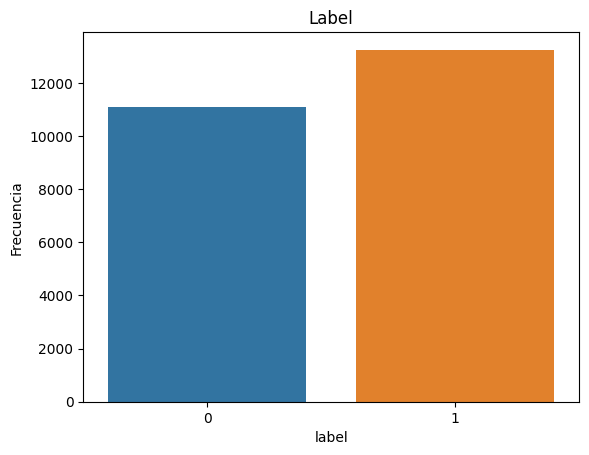

In [77]:
print(train['label'].value_counts())
sns.countplot(data=train,x='label')
plt.title('Label',fontsize=12)
plt.ylabel('Frecuencia')
plt.show()

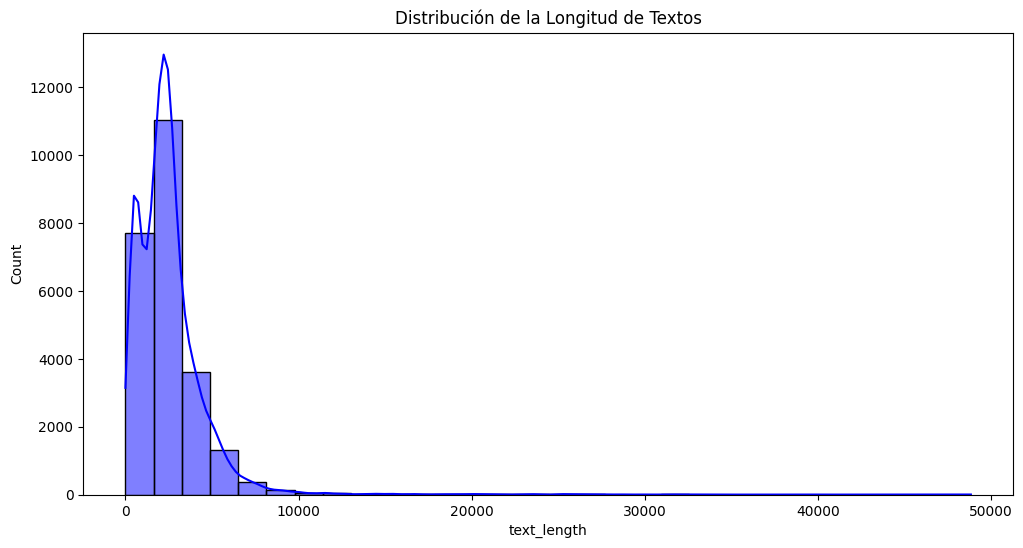

In [78]:
# longitud de caracteres
train['text_length']=train['text'].apply(len)
# longitud de palabras
train['word_count']=train['text'].apply(lambda x: len(x.split()))
# Visualizar distribuciones
plt.figure(figsize=(12, 6))
sns.histplot(train['text_length'], kde=True, bins=30, color='blue')
plt.title('Distribución de la Longitud de Textos')
plt.show()

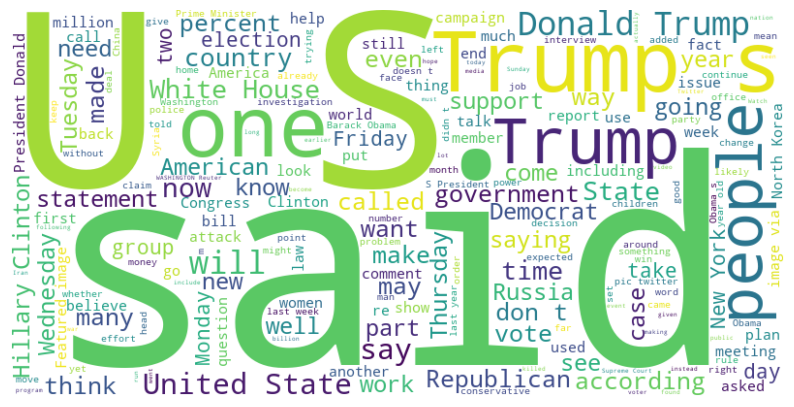

In [79]:
all_text=''.join(train['text'])
# Generar nube de palabras
wordcloud=WordCloud(width=800,height=400,background_color='white').generate(all_text)
# Mostra la nube de carpeta
plt.figure(figsize=(10,8))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

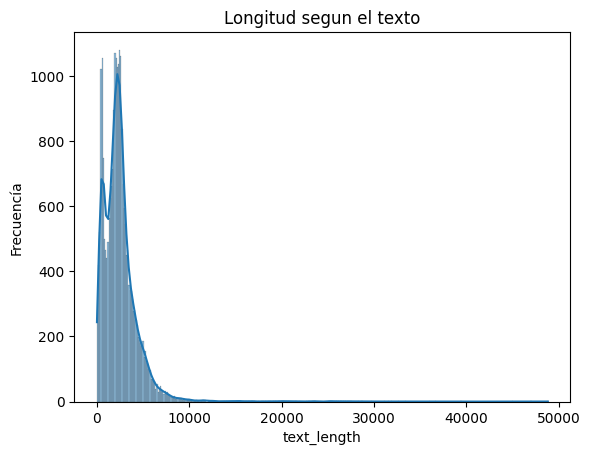

In [80]:
# Relación entre las clases y características del texto
sns.histplot(data=train,x='text_length',kde=True)
plt.title('Longitud segun el texto')
plt.ylabel('Frecuencía')
plt.show()

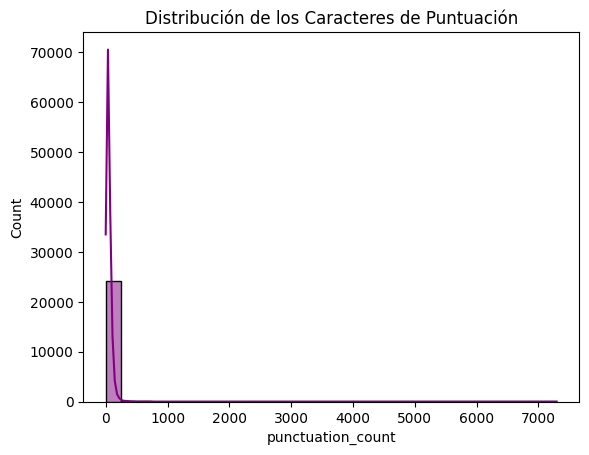

In [81]:
import string
train['punctuation_count'] = train['text'].apply(lambda x: sum(1 for char in x if char in string.punctuation))

# Visualización
sns.histplot(train['punctuation_count'], kde=True, color='purple', bins=30)
plt.title('Distribución de los Caracteres de Puntuación')
plt.show()

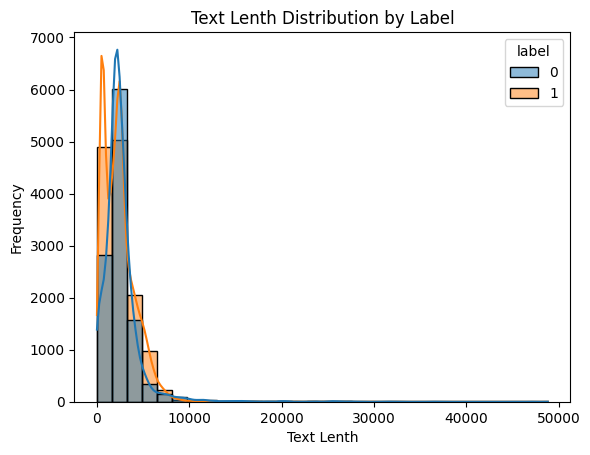

In [82]:
sns.histplot(data=train, x='text_length', hue = 'label', bins=30, kde=True)
plt.title("Text Lenth Distribution by Label")
plt.xlabel('Text Lenth')
plt.ylabel("Frequency")
plt.show()

In [83]:
train.head()

,title,text,label,text_length,word_count,punctuation_count
0,Palestinians switch off Christmas lights in Be...,"RAMALLAH, West Bank (Reuters) - Palestinians s...",1,1335,212,27
1,China says Trump call with Taiwan president wo...,BEIJING (Reuters) - U.S. President-elect Donal...,1,373,59,12
2,FAIL! The Trump Organization’s Credit Score W...,While the controversy over Trump s personal ta...,0,2072,354,42
3,Zimbabwe military chief's China trip was norma...,BEIJING (Reuters) - A trip to Beijing last wee...,1,2692,428,45
4,THE MOST UNCOURAGEOUS PRESIDENT EVER Receives ...,There has never been a more UNCOURAGEOUS perso...,0,1946,314,33


In [84]:
def limpiar_texto(text):
    # convertir a minusculas
    text=text.lower()
    # eliminar urls
    text=re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # eliminar caracteres especiales y números
    text=re.sub(r'[^a-zA-Z\s]', '', text)
    # eliminar espacios extras
    text=re.sub(r'\s+', ' ', text).strip()
    return text

# Aplicar limpieza
train['text_clean']=train['text'].apply(limpiar_texto)
test['text_clean']=test['text'].apply(limpiar_texto)

## **Model of predicción**

In [85]:
X=train['text_clean']
y=train['label']

In [86]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
y=le.fit_transform(y)

In [87]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [88]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(19481,)
(4871,)
(19481,)
(4871,)


**Preparación del texto**

In [89]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train).toarray()
X_test_tfidf = vectorizer.transform(X_test).toarray()

**Construcción del modelo**

In [90]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
# Definir el modelo 
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_tfidf.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Para clasificación binaria
])
# Compilar el modelo
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
# Entrenar el modelo
history = model.fit(X_train_tfidf, y_train, epochs=10, batch_size=32, validation_data=(X_test_tfidf, y_test))

Epoch 1/10
609/609 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8780 - loss: 0.2723 - val_accuracy: 0.9708 - val_loss: 0.0858
Epoch 2/10
609/609 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9847 - loss: 0.0495 - val_accuracy: 0.9680 - val_loss: 0.0930
Epoch 3/10
609/609 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9945 - loss: 0.0190 - val_accuracy: 0.9686 - val_loss: 0.1089
Epoch 4/10
609/609 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9973 - loss: 0.0098 - val_accuracy: 0.9674 - val_loss: 0.1351
Epoch 5/10
609/609 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9991 - loss: 0.0040 - val_accuracy: 0.9667 - val_loss: 0.1725
Epoch 6/10
609/609 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9994 - loss: 0.0022 - val_accuracy: 0.9680 - val_loss: 0.1881
Epoch 7/10
609/609 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9994 - loss: 0.0027 - val_accuracy: 0.9692 - val_loss: 0.1846
Epoch 8/10
609/609 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9980 - loss: 0.0053 - val_accuracy: 0.

## **Evaluation del Modelo**

In [91]:
test_loss,test_accuracy=model.evaluate(X_test_tfidf, y_test)
print(f'Test Accuracy : {test_accuracy:.2f}')

153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9671 - loss: 0.2216
Test Accuracy : 0.97


In [92]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,confusion_matrix
# Generar predicciones
y_pred_prob = model.predict(X_test_tfidf)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [93]:
# Accuracy
accuracy = accuracy_score(y_test, y_pred)

# Precision
precision = precision_score(y_test, y_pred)

# Recall
recall = recall_score(y_test, y_pred)

# F1-Score
f1 = f1_score(y_test, y_pred)

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Mostrar resultados
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"Matriz de confusión:\n{conf_matrix}")


Accuracy: 0.97
Precision: 0.97
Recall: 0.97
F1-Score: 0.97
Matriz de confusión:
[[2128   93]
 [  70 2580]]


## **Predicciones con el Data Test**

In [98]:
X_pred_=test['text_clean']
# Transformar los datos de prueba con el mismo vectorizador usado en el entrenamiento
X_pred_tfidf = vectorizer.transform(X_pred_)
# Predecir las probabilidades o clases
y_pred_prob = model.predict(X_pred_tfidf)  # Si tu modelo retorna probabilidades
y_pred_new = (y_pred_prob > 0.5).astype(int).flatten()  # Convertir a etiquetas (para modelos binarios)

254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [99]:
new_test=test['text_clean']
new_test=pd.DataFrame(new_test)
new_test['predicted_label']=y_pred_new
new_test.head()

,text_clean,predicted_label
0,new york reuters veteran actor and frequent ho...,0
1,barcelona reuters catalonia s independence mov...,1
2,winstonsalem nc reuters north carolina governo...,1
3,washington reuters draft legislation respondin...,1
4,sacramento calif reuters california governor j...,1


In [100]:
new_test['predicted_label'].value_counts()

predicted_label
1    4399
0    3718
Name: count, dtype: int64

In [102]:
url_val='/kaggle/input/fake-news-classification/evaluation.csv'
df_val=pd.read_csv(url_val,sep=';')
df_val['label'].value_counts()

label
1    4314
0    3803
Name: count, dtype: int64